In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [4]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

In [5]:
#paths to CPDB summary files - early and late

early_path = root_path + 'cpdb/cpdb_new_early.tsv'
late_path = root_path + 'cpdb/cpdb_new_late.tsv'

# Cell-cell interactions: Hair follicle formation

In [7]:
# load early CPDB summary file
cpdb_early = pd.read_csv(early_path, delimiter="\t")

In [8]:
cpdb_early

,gene_pair,celltype_pair,mean,p,padj
0,FAM3C|HLA-C,Arterial|ASDC,0.924,0.000,0.000000
1,MIF|CD74,Arterial|ASDC,3.147,0.000,0.000000
2,GRN|TNFRSF1A,Arterial|ASDC,0.705,0.006,0.325909
3,GRN|TNFRSF1B,Arterial|ASDC,0.832,0.000,0.000000
4,COPA|CD74,Arterial|ASDC,2.538,0.000,0.000000
...,...,...,...,...,...
64094,TNFSF13B|TNFRSF17,pDC|pDC,0.204,0.000,0.000000
64095,TNFSF13B|TNFRSF13C,pDC|pDC,0.168,0.000,0.000000
64096,VEGFB|NRP1,pDC|pDC,0.201,0.048,1.000000
64097,TNF|PTPRS,pDC|pDC,0.327,0.006,0.551538


In [9]:
cpdb_late = pd.read_csv(late_path, delimiter="\t")

In [10]:
cpdb_late

,gene_pair,celltype_pair,mean,p,padj
0,CD44|FGFR2,ASDC|Adipocytes,0.597,0.0,0.0
1,TGFB1|TGFBR3,ASDC|Adipocytes,0.705,0.0,0.0
2,FAM3C|HLA-C,Adipocytes|ASDC,1.275,0.0,0.0
3,FAM3C|ADGRG5,Adipocytes|ASDC,0.226,0.0,0.0
4,MIF|CD74,Adipocytes|ASDC,3.392,0.0,0.0
...,...,...,...,...,...
82816,TNFSF13B|TNFRSF17,pDC|pDC,0.218,0.0,0.0
82817,TNFSF13B|TNFRSF13C,pDC|pDC,0.208,0.0,0.0
82818,VEGFB|NRP1,pDC|pDC,0.260,0.0,0.0
82819,COPA|P2RY6,pDC|pDC,0.286,0.0,0.0


In [11]:
bind_all=[cpdb_early, cpdb_late]
cpdb_all = pd.concat(bind_all)

In [12]:
cpdb_all.shape

(146920, 5)

In [13]:
# all fibroblasts
fib = ['Dermal condensate', 'Dermal papillia', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pre-dermal condensate', 'WNT2+ fibroblast']

In [14]:
#keratinocytes = ['Basal KC', 'Early KC (stem cell)', 'Hair follicle', 'Suprabasal']

In [15]:
keratinocytes_joint = ['Basal', 'Companion layer', 'Cuticle/cortex', 'Immature basal', 'Immature suprabasal', 'Inner root sheath', 'Outer root sheath',
                       'POSTN+ basal', 'Suprabasal IFE']

In [16]:
# HF fibroblasts
fib2 = ['Dermal condensate', 'Dermal papillia', 'HOXC5+ early fibroblast', 'Pre-dermal condensate']

In [17]:
# HF fibroblasts - early
fib4 = ['HOXC5+ early fibroblast', 'Pre-dermal condensate']

In [18]:
# HF fibroblasts - late
fib5 = ['Dermal condensate', 'Dermal papillia']

In [20]:
# obtain interactions for early HF fibroblasts
cpdb_fib6 = pd.DataFrame()
for i in fib4:
    print(i)
    temp = cpdb_early[(cpdb_early['celltype_pair'].str.startswith(i)) & (cpdb_early['celltype_pair'].str.contains('basal', case=False))]
    temp['Fibroblast'] = i
    temp['cell_pair'] = i + '_Epithelial_early'
    cpdb_fib6 = pd.concat([cpdb_fib6, temp])
cpdb_fib6

HOXC5+ early fibroblast
Pre-dermal condensate


,gene_pair,celltype_pair,mean,p,padj,Fibroblast,cell_pair
13448,CD44|FGFR2,HOXC5+ early fibroblast|Immature basal,0.617,0.000,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
13449,TIMP1|FGFR2,HOXC5+ early fibroblast|Immature basal,0.633,0.000,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
13450,FGFR1|FGFR2,HOXC5+ early fibroblast|Immature basal,0.726,0.000,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
13451,FGFR2|FGFR3,HOXC5+ early fibroblast|Immature basal,0.116,0.000,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
13455,IGF2|IGF1R,HOXC5+ early fibroblast|Immature basal,0.553,0.000,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
...,...,...,...,...,...,...,...
56242,MDK|LRP1,Pre-dermal condensate|Immature suprabasal,1.100,0.000,0.0,Pre-dermal condensate,Pre-dermal condensate_Epithelial_early
56243,WNT5A|ANTXR1,Pre-dermal condensate|Immature suprabasal,0.211,0.030,1.0,Pre-dermal condensate,Pre-dermal condensate_Epithelial_early
56244,GDF11|ANTXR1,Pre-dermal condensate|Immature suprabasal,0.237,0.024,1.0,Pre-dermal condensate,Pre-dermal condensate_Epithelial_early
56245,FGFR2|EPHA4,Pre-dermal condensate|Immature suprabasal,0.374,0.000,0.0,Pre-dermal condensate,Pre-dermal condensate_Epithelial_early


In [21]:
# remove Immature suprabasal/suprabasal IFE 
cpdb_fib6filt = cpdb_fib6[~ cpdb_fib6['celltype_pair'].str.contains('suprabasal', case=False)]

In [22]:
cpdb_fib6filt.shape

(44, 7)

In [23]:
# obtain interactions for late HF fibroblasts
cpdb_fib7 = pd.DataFrame()
for i in fib5:
    print(i)
    temp = cpdb_late[(cpdb_late['celltype_pair'].str.startswith(i)) & (cpdb_late['celltype_pair'].str.contains('basal|companion|cuticle|placode|sheath', case=False))]
    temp['Fibroblast'] = i
    temp['cell_pair'] = i + '_Epithelial_late'
    cpdb_fib7 = pd.concat([cpdb_fib7, temp])
cpdb_fib7

Dermal condensate
Dermal papillia


,gene_pair,celltype_pair,mean,p,padj,Fibroblast,cell_pair
5108,FAM3C|LAMP1,Dermal condensate|Basal,0.344,0.000,0.000000,Dermal condensate,Dermal condensate_Epithelial_late
5109,FAM3C|CXADR,Dermal condensate|Basal,0.766,0.000,0.000000,Dermal condensate,Dermal condensate_Epithelial_late
5110,TGFB1|EGFR,Dermal condensate|Basal,0.223,0.024,0.655636,Dermal condensate,Dermal condensate_Epithelial_late
5111,MIF|EGFR,Dermal condensate|Basal,1.022,0.029,0.774622,Dermal condensate,Dermal condensate_Epithelial_late
5112,GRN|EGFR,Dermal condensate|Basal,0.485,0.000,0.000000,Dermal condensate,Dermal condensate_Epithelial_late
...,...,...,...,...,...,...,...
75490,MIF|EGFR,Dermal papillia|Suprabasal IFE,1.146,0.000,0.000000,Dermal papillia,Dermal papillia_Epithelial_late
75491,COPA|EGFR,Dermal papillia|Suprabasal IFE,0.312,0.000,0.000000,Dermal papillia,Dermal papillia_Epithelial_late
75494,PTN|PLXNB2,Dermal papillia|Suprabasal IFE,0.426,0.000,0.000000,Dermal papillia,Dermal papillia_Epithelial_late
75495,EFNB1|EPHB6,Dermal papillia|Suprabasal IFE,0.433,0.000,0.000000,Dermal papillia,Dermal papillia_Epithelial_late


In [24]:
# remove Immature suprabasal/suprabasal IFE and Immature basal
cpdb_fib7filt = cpdb_fib7[~ cpdb_fib7['celltype_pair'].str.contains('suprabasal|immature', case=False)]

In [25]:
cpdb_fib7filt.shape

(234, 7)

In [26]:
bind_fib2=[cpdb_fib6filt, cpdb_fib7filt]
cpdb_fib8 = pd.concat(bind_fib2)

In [27]:
cpdb_fib8

,gene_pair,celltype_pair,mean,p,padj,Fibroblast,cell_pair
13448,CD44|FGFR2,HOXC5+ early fibroblast|Immature basal,0.617,0.0,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
13449,TIMP1|FGFR2,HOXC5+ early fibroblast|Immature basal,0.633,0.0,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
13450,FGFR1|FGFR2,HOXC5+ early fibroblast|Immature basal,0.726,0.0,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
13451,FGFR2|FGFR3,HOXC5+ early fibroblast|Immature basal,0.116,0.0,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
13455,IGF2|IGF1R,HOXC5+ early fibroblast|Immature basal,0.553,0.0,0.0,HOXC5+ early fibroblast,HOXC5+ early fibroblast_Epithelial_early
...,...,...,...,...,...,...,...
66746,COPA|EGFR,Dermal papillia|POSTN+ basal,0.411,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
66761,PTN|PLXNB2,Dermal papillia|POSTN+ basal,0.501,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
66763,EFNB1|EPHB6,Dermal papillia|POSTN+ basal,0.371,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late
66765,WNT5A|FZD6,Dermal papillia|POSTN+ basal,0.477,0.0,0.0,Dermal papillia,Dermal papillia_Epithelial_late


In [28]:
print(cpdb_fib8['celltype_pair'].unique())

['HOXC5+ early fibroblast|Immature basal' 'Pre-dermal condensate|Immature basal' 'Dermal condensate|Basal' 'Dermal condensate|Companion layer'
 'Dermal condensate|Cuticle/cortex' 'Dermal condensate|Inner root sheath' 'Dermal condensate|Matrix/placode' 'Dermal condensate|Outer root sheath'
 'Dermal condensate|POSTN+ basal' 'Dermal papillia|Basal' 'Dermal papillia|Companion layer' 'Dermal papillia|Cuticle/cortex'
 'Dermal papillia|Inner root sheath' 'Dermal papillia|Matrix/placode' 'Dermal papillia|Outer root sheath' 'Dermal papillia|POSTN+ basal']


In [29]:
print(cpdb_fib8['cell_pair'].unique())

['HOXC5+ early fibroblast_Epithelial_early' 'Pre-dermal condensate_Epithelial_early' 'Dermal condensate_Epithelial_late'
 'Dermal papillia_Epithelial_late']


In [30]:
# grouby gene_pair/cell_pair and compute mean of interaction means
array_fib8 = cpdb_fib8.groupby(['gene_pair', 'cell_pair'])['mean'].mean().to_frame(name='new_mean').reset_index()
array_fib8

,gene_pair,cell_pair,new_mean
0,BDNF|F11R,HOXC5+ early fibroblast_Epithelial_early,0.098000
1,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.098000
2,BMP7|PTPRK,Dermal condensate_Epithelial_late,0.254600
3,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.767000
4,CD44|FGFR2,Dermal condensate_Epithelial_late,0.487000
...,...,...,...
94,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.198000
95,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.478571
96,WNT5A|PTPRK,Pre-dermal condensate_Epithelial_early,0.195000
97,WNT5A|ROR1,Pre-dermal condensate_Epithelial_early,0.096000


In [31]:
# find min adjusted p-value for each combination of gene_pair-cell_pair
gene_pair = list(array_fib8['gene_pair'])
cell_pair = list(array_fib8['cell_pair'])
cpdb_fib8_p = cpdb_fib8.loc[(cpdb_fib8['gene_pair'].isin(gene_pair)) & (cpdb_fib8['cell_pair'].isin(cell_pair))]
cpdb_fib8_p = cpdb_fib8_p.groupby(['gene_pair', 'cell_pair'])['padj'].min().to_frame(name='min_padj').reset_index()
cpdb_fib8_p

,gene_pair,cell_pair,min_padj
0,BDNF|F11R,HOXC5+ early fibroblast_Epithelial_early,0.000000
1,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.000000
2,BMP7|PTPRK,Dermal condensate_Epithelial_late,0.000000
3,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.000000
4,CD44|FGFR2,Dermal condensate_Epithelial_late,0.138692
...,...,...,...
94,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.000000
95,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.000000
96,WNT5A|PTPRK,Pre-dermal condensate_Epithelial_early,0.000000
97,WNT5A|ROR1,Pre-dermal condensate_Epithelial_early,0.108636


In [32]:
# add min adlisted p-value to means dataframe
gene_pair2 = list(cpdb_fib8_p['gene_pair'])
cell_pair2 = list(cpdb_fib8_p['cell_pair'])
array_fib8.loc[(array_fib8['gene_pair'].isin(gene_pair2)) & (array_fib8['cell_pair'].isin(cell_pair2)), 'min_padj'] = cpdb_fib8_p['min_padj']
array_fib8

,gene_pair,cell_pair,new_mean,min_padj
0,BDNF|F11R,HOXC5+ early fibroblast_Epithelial_early,0.098000,0.000000
1,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.098000,0.000000
2,BMP7|PTPRK,Dermal condensate_Epithelial_late,0.254600,0.000000
3,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.767000,0.000000
4,CD44|FGFR2,Dermal condensate_Epithelial_late,0.487000,0.138692
...,...,...,...,...
94,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.198000,0.000000
95,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.478571,0.000000
96,WNT5A|PTPRK,Pre-dermal condensate_Epithelial_early,0.195000,0.000000
97,WNT5A|ROR1,Pre-dermal condensate_Epithelial_early,0.096000,0.108636


In [33]:
# filter to min adjusted p-value <0.05
array_fib8 = array_fib8[array_fib8['min_padj'] < 0.05]
array_fib8

,gene_pair,cell_pair,new_mean,min_padj
0,BDNF|F11R,HOXC5+ early fibroblast_Epithelial_early,0.098000,0.0
1,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.098000,0.0
2,BMP7|PTPRK,Dermal condensate_Epithelial_late,0.254600,0.0
3,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.767000,0.0
5,CD44|FGFR2,HOXC5+ early fibroblast_Epithelial_early,0.617000,0.0
...,...,...,...,...
93,WNT5A|FZD6,Dermal papillia_Epithelial_late,0.490000,0.0
94,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.198000,0.0
95,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.478571,0.0
96,WNT5A|PTPRK,Pre-dermal condensate_Epithelial_early,0.195000,0.0


In [34]:
array_fib8['Fibroblast'] = [x.split('_')[0] for x in array_fib8['cell_pair']]
array_fib8

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
0,BDNF|F11R,HOXC5+ early fibroblast_Epithelial_early,0.098000,0.0,HOXC5+ early fibroblast
1,BDNF|F11R,Pre-dermal condensate_Epithelial_early,0.098000,0.0,Pre-dermal condensate
2,BMP7|PTPRK,Dermal condensate_Epithelial_late,0.254600,0.0,Dermal condensate
3,BMP7|PTPRK,Dermal papillia_Epithelial_late,0.767000,0.0,Dermal papillia
5,CD44|FGFR2,HOXC5+ early fibroblast_Epithelial_early,0.617000,0.0,HOXC5+ early fibroblast
...,...,...,...,...,...
93,WNT5A|FZD6,Dermal papillia_Epithelial_late,0.490000,0.0,Dermal papillia
94,WNT5A|FZD6,Pre-dermal condensate_Epithelial_early,0.198000,0.0,Pre-dermal condensate
95,WNT5A|PTPRK,Dermal papillia_Epithelial_late,0.478571,0.0,Dermal papillia
96,WNT5A|PTPRK,Pre-dermal condensate_Epithelial_early,0.195000,0.0,Pre-dermal condensate


In [35]:
array_fib8_top = array_fib8.groupby('cell_pair').apply(lambda grp: grp.nlargest(10, 'new_mean')).reset_index(drop=True)
array_fib8_top

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
0,MIF|EGFR,Dermal condensate_Epithelial_late,1.072000,0.0,Dermal condensate
1,FAM3C|CXADR,Dermal condensate_Epithelial_late,0.809000,0.0,Dermal condensate
2,MDK|LRP1,Dermal condensate_Epithelial_late,0.612500,0.0,Dermal condensate
3,TIMP1|FGFR2,Dermal condensate_Epithelial_late,0.612000,0.0,Dermal condensate
4,MDK|SORL1,Dermal condensate_Epithelial_late,0.611500,0.0,Dermal condensate
5,FGFR1|FGFR2,Dermal condensate_Epithelial_late,0.556857,0.0,Dermal condensate
6,GRN|EGFR,Dermal condensate_Epithelial_late,0.497000,0.0,Dermal condensate
7,FAM3C|LAMP1,Dermal condensate_Epithelial_late,0.393000,0.0,Dermal condensate
8,EFNB1|EPHB6,Dermal condensate_Epithelial_late,0.280800,0.0,Dermal condensate
9,FAM3C|PDCD1,Dermal condensate_Epithelial_late,0.274000,0.0,Dermal condensate


In [36]:
# sort cell_pairs
sorter = ['HOXC5+ early fibroblast_Epithelial_early', 'Pre-dermal condensate_Epithelial_early', 'Dermal condensate_Epithelial_late','Dermal papillia_Epithelial_late']
sorterIndex = dict(zip(sorter, range(len(sorter))))
array_fib8_top['cell_pair_Rank'] = array_fib8_top['cell_pair'].map(sorterIndex)
array_fib8_top.sort_values(['cell_pair_Rank', 'new_mean'],ascending = [True, False], inplace = True)
array_fib8_top.drop('cell_pair_Rank', 1, inplace = True)
array_fib8_top

,gene_pair,cell_pair,new_mean,min_padj,Fibroblast
20,MDK|LRP1,HOXC5+ early fibroblast_Epithelial_early,1.575000,0.0,HOXC5+ early fibroblast
21,FGFR1|FGFR2,HOXC5+ early fibroblast_Epithelial_early,0.726000,0.0,HOXC5+ early fibroblast
22,TIMP1|FGFR2,HOXC5+ early fibroblast_Epithelial_early,0.633000,0.0,HOXC5+ early fibroblast
23,CD44|FGFR2,HOXC5+ early fibroblast_Epithelial_early,0.617000,0.0,HOXC5+ early fibroblast
24,CXCL12|ACKR3,HOXC5+ early fibroblast_Epithelial_early,0.576000,0.0,HOXC5+ early fibroblast
25,IGF2|IGF1R,HOXC5+ early fibroblast_Epithelial_early,0.553000,0.0,HOXC5+ early fibroblast
26,GRN|EGFR,HOXC5+ early fibroblast_Epithelial_early,0.471000,0.0,HOXC5+ early fibroblast
27,COPA|EGFR,HOXC5+ early fibroblast_Epithelial_early,0.362000,0.0,HOXC5+ early fibroblast
28,FAM3C|CXADR,HOXC5+ early fibroblast_Epithelial_early,0.329000,0.0,HOXC5+ early fibroblast
29,EPHB6|EFNB2,HOXC5+ early fibroblast_Epithelial_early,0.316000,0.0,HOXC5+ early fibroblast


In [37]:
array_fib8_plot = array_fib8_top.pivot_table(index='gene_pair', columns='cell_pair', values='new_mean', sort=False)

In [38]:
column_order = ['HOXC5+ early fibroblast_Epithelial_early', 'Pre-dermal condensate_Epithelial_early', 'Dermal condensate_Epithelial_late','Dermal papillia_Epithelial_late']
array_fib8_plot = array_fib8_plot.replace(np.nan, 0) # copy df but with nans as 0
array_fib8_plot = array_fib8_plot[column_order] # reorder columns to correct order (x axis)

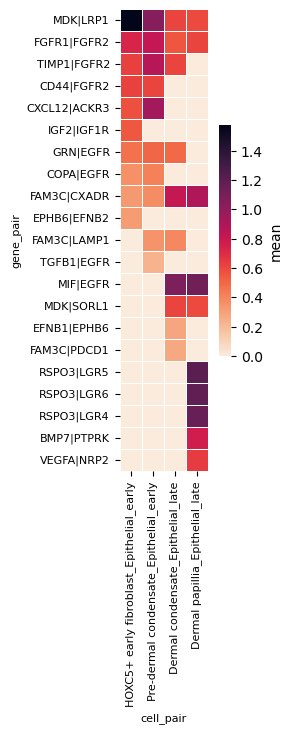

In [40]:
# Plot
plt.subplots(figsize=(3,6))
ax = sn.heatmap(array_fib8_plot, cmap='rocket_r', linewidths=0.5, linecolor='white', square = True, annot=False, xticklabels=1, yticklabels=1, cbar_kws={"shrink": 0.5, 'label':'mean'})
for i in [plt.xticks, plt.yticks]:
    i(fontsize=8) 
for i in [ax.xaxis.label.set_size, ax.yaxis.label.set_size]:
    i(8)
#plt.savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/CPDB_10_23102022.pdf',dpi=300, bbox_inches = "tight")

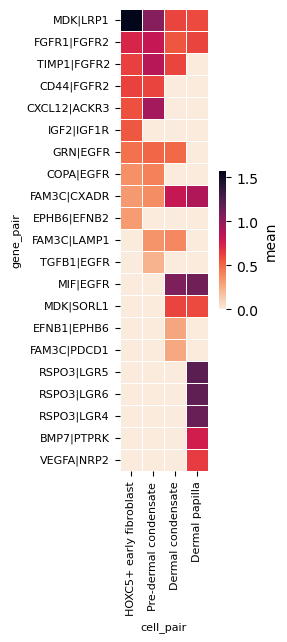

In [41]:
plt.subplots(figsize=(3,6))
ax = sn.heatmap(array_fib8_plot, cmap='rocket_r', linewidths=0.5, linecolor='white', square = True, 
                 annot=False, xticklabels=['HOXC5+ early fibroblast', 'Pre-dermal condensate', 'Dermal condensate','Dermal papilla'], yticklabels=1, cbar_kws={"shrink": 0.3, 'label':'mean'})
for i in [plt.xticks, plt.yticks]:
    i(fontsize=8) 
for i in [ax.xaxis.label.set_size, ax.yaxis.label.set_size]:
    i(8)
#plt.savefig('/home/jovyan/projects/skin/fetal_skin/figures/marker_panels/CPDB_10_23102022_v2.pdf',dpi=300, bbox_inches = "tight")

# Cell-cell interaction: Angiogenesis

In [68]:
# load overall CPDB summary file
joint_path = root_path + 'cpdb/cpdb_summary_joint.tsv'
cpdb = pd.read_csv(joint_path, delimiter="\t")
cpdb

,gene_pair,celltype_pair,mean,p,padj
0,CD44|FGFR2,ASDC|Adipocytes,0.555,0.000,0.0
1,TIMP1|FGFR2,ASDC|Adipocytes,0.584,0.024,1.0
2,TGFB1|TGFBR3,ASDC|Adipocytes,0.722,0.000,0.0
3,FAM3C|HLA-C,Adipocytes|ASDC,1.248,0.000,0.0
4,FAM3C|ADGRG5,Adipocytes|ASDC,0.241,0.000,0.0
...,...,...,...,...,...
102302,TNFSF13B|TNFRSF17,pDC|pDC,0.223,0.000,0.0
102303,TNFSF13B|TNFRSF13C,pDC|pDC,0.210,0.000,0.0
102304,VEGFB|NRP1,pDC|pDC,0.287,0.000,0.0
102305,COPA|P2RY6,pDC|pDC,0.292,0.000,0.0


## Define cell groups

In [69]:
mac = ['Iron-recycling macrophage', 'LYVE1++ macrophage', 'MHCII+ macrophage', 'TREM2+ macrophage']

In [45]:
#immune = ['Iron-recycling macrophage', 'LYVE1++ macrophage', 'MHCII+ macrophage', 'TREM2+ macrophage', 
#          'CD4 T cell', 'CD8 T cell', 'Innate T type1', 'Innate T type3', 'ILC2', 'ILC3']

In [46]:
#lymphoid = ['CD4 T cell', 'CD8 T cell', 'Innate T type1', 'Innate T type3', 'ILC2', 'ILC3', 'NK cell']

In [70]:
endo = ['Early endothelial cell', 'Tip cell (arterial)', 'Arterial', 'Capillary (venular tip)', 'Capillary/postcapillary venule', 'Postcapillary venule']

## Define Immune->endothelium L-R interactions

In [71]:
#Ligand-receptor interactions of interest between macrophages cells --> endothelial cells 
gene_pair= ['PDGFC|FLT4', 'VEGFA|NRP1', 'VEGFA|NRP2', 'VEGFB|NRP1','VEGFA|KDR',  #pro-angiogenic
           'AREG|ICAM1', 'AXL|IL15RA', 'GAS6|MERTK', 'GRN|TNFRSF1A', 'IGF2|IGF1R', #cell proliferation
           'CCL2|ACKR1', 'CCL3|IDE', 'CXCL12|CXCR4', #cell migration
           'CCL8|ACKR1', 'CXCL8|ACKR1', 'LGALS9|PTPRK', 'LGALS9|COLEC12', 'LGALS9|DAG1', 'LGALS9|MET', 'VEGFB|FLT1', 'VEGFA|FLT1', 'TNFSF13|TNFRSF1A' #regulation of cell growth and angiogenesis
           ]
#'TNF|NOTCH1'
#'LTA|TNFRSF1A', 'LTA|LTBR', 'LTA|TNFRSF14',
#'IL13|TMEM219', 'TNFSF11|TNFRSF11A', 'TNF|RIPK1', 'TNFSF10|RIPK1']

In [72]:
# obtain interactions for cell pairs/gene pairs of interest as defined above
cpdb_angio1 = pd.DataFrame()
for i in mac:
    print(i)
    temp = cpdb[(cpdb['celltype_pair'].str.startswith(i)) & (cpdb['gene_pair'].isin(gene_pair)) &
                  (cpdb['celltype_pair'].str.contains('arterial|capillary|endothelial', case=False))]
    temp['Immune'] = i
    temp['broad_immune'] = 'Myeloid'
    temp['ligand'] = 'Immune'
    temp['cell_pair'] = i + '_Endothelial_cells'
    temp['broad_cell_pair'] = 'Myeloid_Endothelial_cells'
    cpdb_angio1 = pd.concat([cpdb_angio1, temp])
cpdb_angio1

Iron-recycling macrophage
LYVE1++ macrophage
MHCII+ macrophage
TREM2+ macrophage


,gene_pair,celltype_pair,mean,p,padj,Immune,broad_immune,ligand,cell_pair,broad_cell_pair
3543,GRN|TNFRSF1A,Iron-recycling macrophage|Arterial,1.252,0.000,0.000000,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
3547,VEGFA|NRP1,Iron-recycling macrophage|Arterial,0.934,0.000,0.000000,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
3548,VEGFA|NRP2,Iron-recycling macrophage|Arterial,0.233,0.032,0.611343,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
3549,VEGFB|NRP1,Iron-recycling macrophage|Arterial,0.917,0.000,0.000000,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
3550,VEGFB|FLT1,Iron-recycling macrophage|Arterial,0.940,0.000,0.000000,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
...,...,...,...,...,...,...,...,...,...,...
98474,GRN|TNFRSF1A,TREM2+ macrophage|Tip cell (arterial),0.851,0.000,0.000000,TREM2+ macrophage,Myeloid,Immune,TREM2+ macrophage_Endothelial_cells,Myeloid_Endothelial_cells
98477,VEGFA|NRP1,TREM2+ macrophage|Tip cell (arterial),0.798,0.000,0.000000,TREM2+ macrophage,Myeloid,Immune,TREM2+ macrophage_Endothelial_cells,Myeloid_Endothelial_cells
98478,VEGFA|NRP2,TREM2+ macrophage|Tip cell (arterial),0.384,0.000,0.000000,TREM2+ macrophage,Myeloid,Immune,TREM2+ macrophage_Endothelial_cells,Myeloid_Endothelial_cells
98479,VEGFB|NRP1,TREM2+ macrophage|Tip cell (arterial),0.680,0.000,0.000000,TREM2+ macrophage,Myeloid,Immune,TREM2+ macrophage_Endothelial_cells,Myeloid_Endothelial_cells


In [73]:
# grouby gene_pair/cell_pair and compute mean of interaction means
cpdb_angiocurated = cpdb_angio1[:]
array_angiocurated = cpdb_angiocurated.groupby(['gene_pair', 'cell_pair'])['mean'].mean().to_frame(name='new_mean').reset_index()
array_angiocurated

,gene_pair,cell_pair,new_mean
0,AREG|ICAM1,Iron-recycling macrophage_Endothelial_cells,0.546250
1,AREG|ICAM1,MHCII+ macrophage_Endothelial_cells,0.679000
2,AXL|IL15RA,Iron-recycling macrophage_Endothelial_cells,0.275000
3,AXL|IL15RA,LYVE1++ macrophage_Endothelial_cells,0.165000
4,AXL|IL15RA,MHCII+ macrophage_Endothelial_cells,0.099000
...,...,...,...
67,VEGFB|FLT1,TREM2+ macrophage_Endothelial_cells,0.570000
68,VEGFB|NRP1,Iron-recycling macrophage_Endothelial_cells,0.792667
69,VEGFB|NRP1,LYVE1++ macrophage_Endothelial_cells,0.761833
70,VEGFB|NRP1,MHCII+ macrophage_Endothelial_cells,0.688333


In [74]:
array_angiocurated['Immune'] = [x.split('_')[0] for x in array_angiocurated['cell_pair']]
array_angiocurated['Ligand'] = 'Immune'
array_angiocurated

,gene_pair,cell_pair,new_mean,Immune,Ligand
0,AREG|ICAM1,Iron-recycling macrophage_Endothelial_cells,0.546250,Iron-recycling macrophage,Immune
1,AREG|ICAM1,MHCII+ macrophage_Endothelial_cells,0.679000,MHCII+ macrophage,Immune
2,AXL|IL15RA,Iron-recycling macrophage_Endothelial_cells,0.275000,Iron-recycling macrophage,Immune
3,AXL|IL15RA,LYVE1++ macrophage_Endothelial_cells,0.165000,LYVE1++ macrophage,Immune
4,AXL|IL15RA,MHCII+ macrophage_Endothelial_cells,0.099000,MHCII+ macrophage,Immune
...,...,...,...,...,...
67,VEGFB|FLT1,TREM2+ macrophage_Endothelial_cells,0.570000,TREM2+ macrophage,Immune
68,VEGFB|NRP1,Iron-recycling macrophage_Endothelial_cells,0.792667,Iron-recycling macrophage,Immune
69,VEGFB|NRP1,LYVE1++ macrophage_Endothelial_cells,0.761833,LYVE1++ macrophage,Immune
70,VEGFB|NRP1,MHCII+ macrophage_Endothelial_cells,0.688333,MHCII+ macrophage,Immune


In [75]:
array_angio_top = array_angiocurated[:]
array_angio_top

,gene_pair,cell_pair,new_mean,Immune,Ligand
0,AREG|ICAM1,Iron-recycling macrophage_Endothelial_cells,0.546250,Iron-recycling macrophage,Immune
1,AREG|ICAM1,MHCII+ macrophage_Endothelial_cells,0.679000,MHCII+ macrophage,Immune
2,AXL|IL15RA,Iron-recycling macrophage_Endothelial_cells,0.275000,Iron-recycling macrophage,Immune
3,AXL|IL15RA,LYVE1++ macrophage_Endothelial_cells,0.165000,LYVE1++ macrophage,Immune
4,AXL|IL15RA,MHCII+ macrophage_Endothelial_cells,0.099000,MHCII+ macrophage,Immune
...,...,...,...,...,...
67,VEGFB|FLT1,TREM2+ macrophage_Endothelial_cells,0.570000,TREM2+ macrophage,Immune
68,VEGFB|NRP1,Iron-recycling macrophage_Endothelial_cells,0.792667,Iron-recycling macrophage,Immune
69,VEGFB|NRP1,LYVE1++ macrophage_Endothelial_cells,0.761833,LYVE1++ macrophage,Immune
70,VEGFB|NRP1,MHCII+ macrophage_Endothelial_cells,0.688333,MHCII+ macrophage,Immune


In [76]:
gene_pair = list(array_angio_top['gene_pair'])
cell_pair = list(array_angio_top['cell_pair'])
cpdb_angionew = cpdb_angiocurated.loc[(cpdb_angiocurated['gene_pair'].isin(gene_pair)) & (cpdb_angiocurated['cell_pair'].isin(cell_pair))]

In [77]:
cpdb_angionew

,gene_pair,celltype_pair,mean,p,padj,Immune,broad_immune,ligand,cell_pair,broad_cell_pair
3543,GRN|TNFRSF1A,Iron-recycling macrophage|Arterial,1.252,0.000,0.000000,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
3547,VEGFA|NRP1,Iron-recycling macrophage|Arterial,0.934,0.000,0.000000,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
3548,VEGFA|NRP2,Iron-recycling macrophage|Arterial,0.233,0.032,0.611343,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
3549,VEGFB|NRP1,Iron-recycling macrophage|Arterial,0.917,0.000,0.000000,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
3550,VEGFB|FLT1,Iron-recycling macrophage|Arterial,0.940,0.000,0.000000,Iron-recycling macrophage,Myeloid,Immune,Iron-recycling macrophage_Endothelial_cells,Myeloid_Endothelial_cells
...,...,...,...,...,...,...,...,...,...,...
98474,GRN|TNFRSF1A,TREM2+ macrophage|Tip cell (arterial),0.851,0.000,0.000000,TREM2+ macrophage,Myeloid,Immune,TREM2+ macrophage_Endothelial_cells,Myeloid_Endothelial_cells
98477,VEGFA|NRP1,TREM2+ macrophage|Tip cell (arterial),0.798,0.000,0.000000,TREM2+ macrophage,Myeloid,Immune,TREM2+ macrophage_Endothelial_cells,Myeloid_Endothelial_cells
98478,VEGFA|NRP2,TREM2+ macrophage|Tip cell (arterial),0.384,0.000,0.000000,TREM2+ macrophage,Myeloid,Immune,TREM2+ macrophage_Endothelial_cells,Myeloid_Endothelial_cells
98479,VEGFB|NRP1,TREM2+ macrophage|Tip cell (arterial),0.680,0.000,0.000000,TREM2+ macrophage,Myeloid,Immune,TREM2+ macrophage_Endothelial_cells,Myeloid_Endothelial_cells


In [78]:
# find min adjusted p-value for each combination of gene_pair-cell_pair
cpdb_angionewmin = cpdb_angionew.groupby(['gene_pair', 'cell_pair'])['padj'].min().to_frame(name='min_padj').reset_index()
cpdb_angionewmin

,gene_pair,cell_pair,min_padj
0,AREG|ICAM1,Iron-recycling macrophage_Endothelial_cells,0.0
1,AREG|ICAM1,MHCII+ macrophage_Endothelial_cells,0.0
2,AXL|IL15RA,Iron-recycling macrophage_Endothelial_cells,0.0
3,AXL|IL15RA,LYVE1++ macrophage_Endothelial_cells,0.0
4,AXL|IL15RA,MHCII+ macrophage_Endothelial_cells,0.0
...,...,...,...
67,VEGFB|FLT1,TREM2+ macrophage_Endothelial_cells,0.0
68,VEGFB|NRP1,Iron-recycling macrophage_Endothelial_cells,0.0
69,VEGFB|NRP1,LYVE1++ macrophage_Endothelial_cells,0.0
70,VEGFB|NRP1,MHCII+ macrophage_Endothelial_cells,0.0


In [79]:
gene_pair2 = list(cpdb_angionewmin['gene_pair'])
cell_pair2 = list(cpdb_angionewmin['cell_pair'])

In [80]:
array_angio_top.loc[(array_angio_top['gene_pair'].isin(gene_pair2)) & (array_angio_top['cell_pair'].isin(cell_pair2)), 'min_padj'] = cpdb_angionewmin['min_padj']

In [81]:
array_angio_top = array_angio_top[array_angio_top['min_padj'] < 0.05]
array_angio_top

,gene_pair,cell_pair,new_mean,Immune,Ligand,min_padj
0,AREG|ICAM1,Iron-recycling macrophage_Endothelial_cells,0.546250,Iron-recycling macrophage,Immune,0.0
1,AREG|ICAM1,MHCII+ macrophage_Endothelial_cells,0.679000,MHCII+ macrophage,Immune,0.0
2,AXL|IL15RA,Iron-recycling macrophage_Endothelial_cells,0.275000,Iron-recycling macrophage,Immune,0.0
3,AXL|IL15RA,LYVE1++ macrophage_Endothelial_cells,0.165000,LYVE1++ macrophage,Immune,0.0
4,AXL|IL15RA,MHCII+ macrophage_Endothelial_cells,0.099000,MHCII+ macrophage,Immune,0.0
...,...,...,...,...,...,...
67,VEGFB|FLT1,TREM2+ macrophage_Endothelial_cells,0.570000,TREM2+ macrophage,Immune,0.0
68,VEGFB|NRP1,Iron-recycling macrophage_Endothelial_cells,0.792667,Iron-recycling macrophage,Immune,0.0
69,VEGFB|NRP1,LYVE1++ macrophage_Endothelial_cells,0.761833,LYVE1++ macrophage,Immune,0.0
70,VEGFB|NRP1,MHCII+ macrophage_Endothelial_cells,0.688333,MHCII+ macrophage,Immune,0.0


In [82]:
array_angio_top['Endo_mural'] = [x.split('_',1)[1] for x in array_angio_top['cell_pair']]
array_angio_top['Immune_broad'] = np.where(array_angio_top['Immune'].str.contains('macrophage'), 'myeloid', 'lymphoid')
array_angio_top

In [84]:
sorter1 =['PDGFC|FLT4', 'VEGFA|NRP1', 'VEGFA|NRP2', 'VEGFB|NRP1','VEGFA|KDR',  #pro-angiogenic
           'AREG|ICAM1', 'AXL|IL15RA', 'GAS6|MERTK', 'GRN|TNFRSF1A', 'IGF2|IGF1R', #cell proliferation
           'CCL2|ACKR1', 'CCL3|IDE', 'CXCL12|CXCR4', #cell migration
           'CCL8|ACKR1','CXCL8|ACKR1', 'LGALS9|PTPRK', 'LGALS9|COLEC12', 'LGALS9|DAG1', 'LGALS9|MET', 'VEGFB|FLT1', 'VEGFA|FLT1', 'TNFSF13|TNFRSF1A']
sorterIndex1 = dict(zip(sorter1, range(len(sorter1))))

In [85]:
sorter2 = ['Iron-recycling macrophage_Endothelial_cells', 'LYVE1++ macrophage_Endothelial_cells', 'MHCII+ macrophage_Endothelial_cells', 'TREM2+ macrophage_Endothelial_cells']
          #'Iron-recycling macrophage_Mural_cells', 'LYVE1++ macrophage_Mural_cells', 'MHCII+ macrophage_Mural_cells', 'TREM2+ macrophage_Mural_cells',
sorterIndex2 = dict(zip(sorter2, range(len(sorter2))))

In [86]:
array_angio_top['gene_pair_Rank'] = array_angio_top['gene_pair'].map(sorterIndex1)
array_angio_top['cell_pair_Rank'] = array_angio_top['cell_pair'].map(sorterIndex2)

In [88]:
array_angio_top.sort_values(['gene_pair_Rank', 'cell_pair_Rank', 'new_mean'],ascending = [True, True, False], inplace = True)
array_angio_top

,gene_pair,cell_pair,new_mean,Immune,Ligand,min_padj,Endo_mural,Immune_broad,gene_pair_Rank,cell_pair_Rank
45,PDGFC|FLT4,Iron-recycling macrophage_Endothelial_cells,0.210500,Iron-recycling macrophage,Immune,0.0,Endothelial_cells,myeloid,0,0
46,PDGFC|FLT4,LYVE1++ macrophage_Endothelial_cells,0.227333,LYVE1++ macrophage,Immune,0.0,Endothelial_cells,myeloid,0,1
56,VEGFA|NRP1,Iron-recycling macrophage_Endothelial_cells,0.808833,Iron-recycling macrophage,Immune,0.0,Endothelial_cells,myeloid,1,0
57,VEGFA|NRP1,LYVE1++ macrophage_Endothelial_cells,0.800333,LYVE1++ macrophage,Immune,0.0,Endothelial_cells,myeloid,1,1
58,VEGFA|NRP1,MHCII+ macrophage_Endothelial_cells,0.872833,MHCII+ macrophage,Immune,0.0,Endothelial_cells,myeloid,1,2
...,...,...,...,...,...,...,...,...,...,...
48,VEGFA|FLT1,Iron-recycling macrophage_Endothelial_cells,0.689167,Iron-recycling macrophage,Immune,0.0,Endothelial_cells,myeloid,20,0
49,VEGFA|FLT1,LYVE1++ macrophage_Endothelial_cells,0.680667,LYVE1++ macrophage,Immune,0.0,Endothelial_cells,myeloid,20,1
50,VEGFA|FLT1,MHCII+ macrophage_Endothelial_cells,0.753333,MHCII+ macrophage,Immune,0.0,Endothelial_cells,myeloid,20,2
51,VEGFA|FLT1,TREM2+ macrophage_Endothelial_cells,0.688000,TREM2+ macrophage,Immune,0.0,Endothelial_cells,myeloid,20,3


In [89]:
array_angio_top = array_angio_top.drop('Endo_mural', 1)

In [90]:
array_angio_top['Ligand'] = 'Ligand: Immune cells'
array_angio_top

,gene_pair,cell_pair,new_mean,Immune,Ligand,min_padj,Immune_broad,gene_pair_Rank,cell_pair_Rank
45,PDGFC|FLT4,Iron-recycling macrophage_Endothelial_cells,0.210500,Iron-recycling macrophage,Ligand: Immune cells,0.0,myeloid,0,0
46,PDGFC|FLT4,LYVE1++ macrophage_Endothelial_cells,0.227333,LYVE1++ macrophage,Ligand: Immune cells,0.0,myeloid,0,1
56,VEGFA|NRP1,Iron-recycling macrophage_Endothelial_cells,0.808833,Iron-recycling macrophage,Ligand: Immune cells,0.0,myeloid,1,0
57,VEGFA|NRP1,LYVE1++ macrophage_Endothelial_cells,0.800333,LYVE1++ macrophage,Ligand: Immune cells,0.0,myeloid,1,1
58,VEGFA|NRP1,MHCII+ macrophage_Endothelial_cells,0.872833,MHCII+ macrophage,Ligand: Immune cells,0.0,myeloid,1,2
...,...,...,...,...,...,...,...,...,...
48,VEGFA|FLT1,Iron-recycling macrophage_Endothelial_cells,0.689167,Iron-recycling macrophage,Ligand: Immune cells,0.0,myeloid,20,0
49,VEGFA|FLT1,LYVE1++ macrophage_Endothelial_cells,0.680667,LYVE1++ macrophage,Ligand: Immune cells,0.0,myeloid,20,1
50,VEGFA|FLT1,MHCII+ macrophage_Endothelial_cells,0.753333,MHCII+ macrophage,Ligand: Immune cells,0.0,myeloid,20,2
51,VEGFA|FLT1,TREM2+ macrophage_Endothelial_cells,0.688000,TREM2+ macrophage,Ligand: Immune cells,0.0,myeloid,20,3


In [46]:
#save as csv to import to R for plotting using ggplot
#array_angio_top.to_csv('/home/jovyan/projects/skin/fetal_skin/cpdb/angiocurated_R_myeloid_171022.csv')

## Define endothelium->immune L-R interactions

In [91]:
gene_pair= ['ANXA1|FPR1', 'ANX1|FPR3', 'CCL14|CCR1', 'CCL23|CCR1', 'IL16|GRIN2C', #mac chemotaxis
            'PGF|NRP1', 'PGF|NRP2', 'CCL8|CCR1', #endothelial cell proliferation
           'PLXNB1|SEMA4D',  'SPP1|CD44', 'TNFSF12|TNFRSF12A', # EC migration
           'LGALS9|MRC2', 'SPP1|PTGER4', 'FGFR1|NCAM1' #cell-matrix interaction
           ] 
#'CD55|ADGRE5', 'SEMA3F|NRP2', 'LGALS9|PTPRK',  'EFNA1|EPHA4', 'AREG|ICAM1',
#'CXCL12|DPP4', 'CXCL12|CXCR3', 'CCL21|CCR7',
# 'VEGFB|NRP1'

In [92]:
# obtain interactions for cell pairs/gene pairs of interest as defined above
cpdb_endo1 = pd.DataFrame()
for i in endo:
    print(i)
    temp = cpdb[(cpdb['celltype_pair'].str.startswith(i)) & (cpdb['gene_pair'].isin(gene_pair)) &
                  (cpdb['celltype_pair'].str.contains('macrophage', case=False))]
    temp['Vascular'] = i
    temp['broad_endothelial'] = 'Vascular_endothelial'
    temp['ligand'] = 'Endothelial cells'
    temp['cell_pair'] = i + '_myeloid_cells'
    temp['broad_cell_pair'] = 'Endothelial_Myeloid_cells'
    cpdb_endo1 = pd.concat([cpdb_endo1, temp])
cpdb_endo1

Early endothelial cell
Tip cell (arterial)
Arterial
Capillary (venular tip)
Capillary/postcapillary venule
Postcapillary venule


,gene_pair,celltype_pair,mean,p,padj,Vascular,broad_endothelial,ligand,cell_pair,broad_cell_pair
23216,ANXA1|FPR1,Early endothelial cell|Iron-recycling macrophage,0.582,0.038,0.917736,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
23310,PLXNB1|SEMA4D,Early endothelial cell|LYVE1++ macrophage,0.095,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
23373,ANXA1|FPR1,Early endothelial cell|MHCII+ macrophage,0.664,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
23918,PLXNB1|SEMA4D,Early endothelial cell|TREM2+ macrophage,0.111,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
23920,ANXA1|FPR1,Early endothelial cell|TREM2+ macrophage,0.880,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
...,...,...,...,...,...,...,...,...,...,...
95015,CCL23|CCR1,Capillary/postcapillary venule|TREM2+ macrophage,0.266,0.000,0.000000,Capillary/postcapillary venule,Vascular_endothelial,Endothelial cells,Capillary/postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells
87090,ANXA1|FPR1,Postcapillary venule|Iron-recycling macrophage,0.658,0.023,0.482623,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells
87313,ANXA1|FPR1,Postcapillary venule|MHCII+ macrophage,0.740,0.007,0.179200,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells
88050,LGALS9|MRC2,Postcapillary venule|TREM2+ macrophage,0.249,0.000,0.000000,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells


In [93]:
cpdb_endocurated = cpdb_endo1[:]
cpdb_endocurated

,gene_pair,celltype_pair,mean,p,padj,Vascular,broad_endothelial,ligand,cell_pair,broad_cell_pair
23216,ANXA1|FPR1,Early endothelial cell|Iron-recycling macrophage,0.582,0.038,0.917736,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
23310,PLXNB1|SEMA4D,Early endothelial cell|LYVE1++ macrophage,0.095,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
23373,ANXA1|FPR1,Early endothelial cell|MHCII+ macrophage,0.664,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
23918,PLXNB1|SEMA4D,Early endothelial cell|TREM2+ macrophage,0.111,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
23920,ANXA1|FPR1,Early endothelial cell|TREM2+ macrophage,0.880,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells
...,...,...,...,...,...,...,...,...,...,...
95015,CCL23|CCR1,Capillary/postcapillary venule|TREM2+ macrophage,0.266,0.000,0.000000,Capillary/postcapillary venule,Vascular_endothelial,Endothelial cells,Capillary/postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells
87090,ANXA1|FPR1,Postcapillary venule|Iron-recycling macrophage,0.658,0.023,0.482623,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells
87313,ANXA1|FPR1,Postcapillary venule|MHCII+ macrophage,0.740,0.007,0.179200,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells
88050,LGALS9|MRC2,Postcapillary venule|TREM2+ macrophage,0.249,0.000,0.000000,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells


In [94]:
cpdb_endocurated['Immune'] = [x.split('|')[1] for x in cpdb_endocurated['celltype_pair']]
cpdb_endocurated['cell_pair2'] = 'Endothelial' + '_' + cpdb_endocurated['Immune'].astype(str)
cpdb_endocurated

,gene_pair,celltype_pair,mean,p,padj,Vascular,broad_endothelial,ligand,cell_pair,broad_cell_pair,Immune,cell_pair2
23216,ANXA1|FPR1,Early endothelial cell|Iron-recycling macrophage,0.582,0.038,0.917736,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells,Iron-recycling macrophage,Endothelial_Iron-recycling macrophage
23310,PLXNB1|SEMA4D,Early endothelial cell|LYVE1++ macrophage,0.095,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells,LYVE1++ macrophage,Endothelial_LYVE1++ macrophage
23373,ANXA1|FPR1,Early endothelial cell|MHCII+ macrophage,0.664,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells,MHCII+ macrophage,Endothelial_MHCII+ macrophage
23918,PLXNB1|SEMA4D,Early endothelial cell|TREM2+ macrophage,0.111,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells,TREM2+ macrophage,Endothelial_TREM2+ macrophage
23920,ANXA1|FPR1,Early endothelial cell|TREM2+ macrophage,0.880,0.000,0.000000,Early endothelial cell,Vascular_endothelial,Endothelial cells,Early endothelial cell_myeloid_cells,Endothelial_Myeloid_cells,TREM2+ macrophage,Endothelial_TREM2+ macrophage
...,...,...,...,...,...,...,...,...,...,...,...,...
95015,CCL23|CCR1,Capillary/postcapillary venule|TREM2+ macrophage,0.266,0.000,0.000000,Capillary/postcapillary venule,Vascular_endothelial,Endothelial cells,Capillary/postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells,TREM2+ macrophage,Endothelial_TREM2+ macrophage
87090,ANXA1|FPR1,Postcapillary venule|Iron-recycling macrophage,0.658,0.023,0.482623,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells,Iron-recycling macrophage,Endothelial_Iron-recycling macrophage
87313,ANXA1|FPR1,Postcapillary venule|MHCII+ macrophage,0.740,0.007,0.179200,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells,MHCII+ macrophage,Endothelial_MHCII+ macrophage
88050,LGALS9|MRC2,Postcapillary venule|TREM2+ macrophage,0.249,0.000,0.000000,Postcapillary venule,Vascular_endothelial,Endothelial cells,Postcapillary venule_myeloid_cells,Endothelial_Myeloid_cells,TREM2+ macrophage,Endothelial_TREM2+ macrophage


In [95]:
# grouby gene_pair/cell_pair and compute mean of interaction means
array_endocurated = cpdb_endocurated.groupby(['gene_pair', 'cell_pair2'])['mean'].mean().to_frame(name='new_mean').reset_index()
array_endocurated['Immune'] = [x.split('_')[1] for x in array_endocurated['cell_pair2']]
array_endocurated['Ligand'] = 'Endothelial cells'
array_endocurated

,gene_pair,cell_pair2,new_mean,Immune,Ligand
0,ANXA1|FPR1,Endothelial_Iron-recycling macrophage,0.740000,Iron-recycling macrophage,Endothelial cells
1,ANXA1|FPR1,Endothelial_LYVE1++ macrophage,0.736250,LYVE1++ macrophage,Endothelial cells
2,ANXA1|FPR1,Endothelial_MHCII+ macrophage,0.822000,MHCII+ macrophage,Endothelial cells
3,ANXA1|FPR1,Endothelial_TREM2+ macrophage,1.038000,TREM2+ macrophage,Endothelial cells
4,CCL14|CCR1,Endothelial_Iron-recycling macrophage,0.387333,Iron-recycling macrophage,Endothelial cells
5,CCL14|CCR1,Endothelial_LYVE1++ macrophage,0.394333,LYVE1++ macrophage,Endothelial cells
6,CCL14|CCR1,Endothelial_MHCII+ macrophage,0.321333,MHCII+ macrophage,Endothelial cells
7,CCL14|CCR1,Endothelial_TREM2+ macrophage,0.409333,TREM2+ macrophage,Endothelial cells
8,CCL23|CCR1,Endothelial_Iron-recycling macrophage,0.234500,Iron-recycling macrophage,Endothelial cells
9,CCL23|CCR1,Endothelial_LYVE1++ macrophage,0.241500,LYVE1++ macrophage,Endothelial cells


In [96]:
array_endo_top = array_endocurated[:]
array_endo_top

,gene_pair,cell_pair2,new_mean,Immune,Ligand
0,ANXA1|FPR1,Endothelial_Iron-recycling macrophage,0.740000,Iron-recycling macrophage,Endothelial cells
1,ANXA1|FPR1,Endothelial_LYVE1++ macrophage,0.736250,LYVE1++ macrophage,Endothelial cells
2,ANXA1|FPR1,Endothelial_MHCII+ macrophage,0.822000,MHCII+ macrophage,Endothelial cells
3,ANXA1|FPR1,Endothelial_TREM2+ macrophage,1.038000,TREM2+ macrophage,Endothelial cells
4,CCL14|CCR1,Endothelial_Iron-recycling macrophage,0.387333,Iron-recycling macrophage,Endothelial cells
5,CCL14|CCR1,Endothelial_LYVE1++ macrophage,0.394333,LYVE1++ macrophage,Endothelial cells
6,CCL14|CCR1,Endothelial_MHCII+ macrophage,0.321333,MHCII+ macrophage,Endothelial cells
7,CCL14|CCR1,Endothelial_TREM2+ macrophage,0.409333,TREM2+ macrophage,Endothelial cells
8,CCL23|CCR1,Endothelial_Iron-recycling macrophage,0.234500,Iron-recycling macrophage,Endothelial cells
9,CCL23|CCR1,Endothelial_LYVE1++ macrophage,0.241500,LYVE1++ macrophage,Endothelial cells


In [97]:
# find min adjusted p-value for each combination of gene_pair-cell_pair
gene_pair = list(array_endo_top['gene_pair'])
cell_pair = list(array_endo_top['cell_pair2'])
cpdb_endonew = cpdb_endocurated.loc[(cpdb_endocurated['gene_pair'].isin(gene_pair)) & (cpdb_endocurated['cell_pair2'].isin(cell_pair))]
cpdb_endonewmin = cpdb_endonew.groupby(['gene_pair', 'cell_pair2'])['padj'].min().to_frame(name='min_padj').reset_index()
cpdb_endonewmin

,gene_pair,cell_pair2,min_padj
0,ANXA1|FPR1,Endothelial_Iron-recycling macrophage,0.0
1,ANXA1|FPR1,Endothelial_LYVE1++ macrophage,0.0
2,ANXA1|FPR1,Endothelial_MHCII+ macrophage,0.0
3,ANXA1|FPR1,Endothelial_TREM2+ macrophage,0.0
4,CCL14|CCR1,Endothelial_Iron-recycling macrophage,0.0
5,CCL14|CCR1,Endothelial_LYVE1++ macrophage,0.0
6,CCL14|CCR1,Endothelial_MHCII+ macrophage,0.0
7,CCL14|CCR1,Endothelial_TREM2+ macrophage,0.0
8,CCL23|CCR1,Endothelial_Iron-recycling macrophage,0.0
9,CCL23|CCR1,Endothelial_LYVE1++ macrophage,0.0


In [98]:
gene_pair2 = list(cpdb_endonewmin['gene_pair'])
cell_pair2 = list(cpdb_endonewmin['cell_pair2'])
array_endo_top.loc[(array_endo_top['gene_pair'].isin(gene_pair2)) & (array_endo_top['cell_pair2'].isin(cell_pair2)), 'min_padj'] = cpdb_endonewmin['min_padj']
array_endo_top.shape

(35, 6)

In [99]:
array_angio_top = array_angio_top[array_angio_top['min_padj'] < 0.05]
array_endo_top

,gene_pair,cell_pair2,new_mean,Immune,Ligand,min_padj
0,ANXA1|FPR1,Endothelial_Iron-recycling macrophage,0.740000,Iron-recycling macrophage,Endothelial cells,0.0
1,ANXA1|FPR1,Endothelial_LYVE1++ macrophage,0.736250,LYVE1++ macrophage,Endothelial cells,0.0
2,ANXA1|FPR1,Endothelial_MHCII+ macrophage,0.822000,MHCII+ macrophage,Endothelial cells,0.0
3,ANXA1|FPR1,Endothelial_TREM2+ macrophage,1.038000,TREM2+ macrophage,Endothelial cells,0.0
4,CCL14|CCR1,Endothelial_Iron-recycling macrophage,0.387333,Iron-recycling macrophage,Endothelial cells,0.0
5,CCL14|CCR1,Endothelial_LYVE1++ macrophage,0.394333,LYVE1++ macrophage,Endothelial cells,0.0
6,CCL14|CCR1,Endothelial_MHCII+ macrophage,0.321333,MHCII+ macrophage,Endothelial cells,0.0
7,CCL14|CCR1,Endothelial_TREM2+ macrophage,0.409333,TREM2+ macrophage,Endothelial cells,0.0
8,CCL23|CCR1,Endothelial_Iron-recycling macrophage,0.234500,Iron-recycling macrophage,Endothelial cells,0.0
9,CCL23|CCR1,Endothelial_LYVE1++ macrophage,0.241500,LYVE1++ macrophage,Endothelial cells,0.0


In [100]:
array_endo_top['Immune_broad'] = np.where(array_endo_top['Immune'].str.contains('macrophage'), 'myeloid', 'lymphoid')

In [101]:
sorter1 =['ANXA1|FPR1', 'ANX1|FPR3', 'CCL14|CCR1', 'CCL23|CCR1', 'IL16|GRIN2C', #mac chemotaxis
            'PGF|NRP1', 'PGF|NRP2', 'VEGFB|NRP1', 'CCL8|CCR1', #endothelial cell proliferation
           'PLXNB1|SEMA4D', 'SPP1|CD44', 'TNFSF12|TNFRSF12A', # EC migration
           'LGALS9|MRC2', 'SPP1|PTGER4', 'FGFR1|NCAM1' #cell-matrix interaction
         ]
sorterIndex1 = dict(zip(sorter1, range(len(sorter1))))
# 'CD55|ADGRE5', 'SEMA3F|NRP2', 'LGALS9|PTPRK'

In [102]:
sorter2 = ['Endothelial_Iron-recycling macrophage', 'Endothelial_LYVE1++ macrophage', 'Endothelial_MHCII+ macrophage', 'Endothelial_TREM2+ macrophage']
sorterIndex2 = dict(zip(sorter2, range(len(sorter2))))

In [103]:
array_endo_top['gene_pair_Rank'] = array_endo_top['gene_pair'].map(sorterIndex1)
array_endo_top['cell_pair_Rank'] = array_endo_top['cell_pair2'].map(sorterIndex2)
array_endo_top.sort_values(['gene_pair_Rank', 'cell_pair_Rank', 'new_mean'],ascending = [True, True, False], inplace = True)
array_endo_top

,gene_pair,cell_pair2,new_mean,Immune,Ligand,min_padj,Immune_broad,gene_pair_Rank,cell_pair_Rank
0,ANXA1|FPR1,Endothelial_Iron-recycling macrophage,0.740000,Iron-recycling macrophage,Endothelial cells,0.0,myeloid,0,0
1,ANXA1|FPR1,Endothelial_LYVE1++ macrophage,0.736250,LYVE1++ macrophage,Endothelial cells,0.0,myeloid,0,1
2,ANXA1|FPR1,Endothelial_MHCII+ macrophage,0.822000,MHCII+ macrophage,Endothelial cells,0.0,myeloid,0,2
3,ANXA1|FPR1,Endothelial_TREM2+ macrophage,1.038000,TREM2+ macrophage,Endothelial cells,0.0,myeloid,0,3
4,CCL14|CCR1,Endothelial_Iron-recycling macrophage,0.387333,Iron-recycling macrophage,Endothelial cells,0.0,myeloid,2,0
5,CCL14|CCR1,Endothelial_LYVE1++ macrophage,0.394333,LYVE1++ macrophage,Endothelial cells,0.0,myeloid,2,1
6,CCL14|CCR1,Endothelial_MHCII+ macrophage,0.321333,MHCII+ macrophage,Endothelial cells,0.0,myeloid,2,2
7,CCL14|CCR1,Endothelial_TREM2+ macrophage,0.409333,TREM2+ macrophage,Endothelial cells,0.0,myeloid,2,3
8,CCL23|CCR1,Endothelial_Iron-recycling macrophage,0.234500,Iron-recycling macrophage,Endothelial cells,0.0,myeloid,3,0
9,CCL23|CCR1,Endothelial_LYVE1++ macrophage,0.241500,LYVE1++ macrophage,Endothelial cells,0.0,myeloid,3,1


In [104]:
array_endo_top = array_endo_top.rename({'cell_pair2': 'cell_pair'}, axis=1) 

In [105]:
array_endo_top['Ligand'] = 'Ligand: Endothelial cells'

In [86]:
#save as csv to import to R for plotting using ggplot
#array_endo_top.to_csv('/home/jovyan/projects/skin/fetal_skin/cpdb/endocurated_R_myeloid_171022.csv')

In [106]:
# combine dfs: immune->endothelium & endothelium->immune
bind4 = [array_angio_top, array_endo_top]
combined_curated = pd.concat(bind4)
combined_curated

,gene_pair,cell_pair,new_mean,Immune,Ligand,min_padj,Immune_broad,gene_pair_Rank,cell_pair_Rank
45,PDGFC|FLT4,Iron-recycling macrophage_Endothelial_cells,0.210500,Iron-recycling macrophage,Ligand: Immune cells,0.0,myeloid,0,0
46,PDGFC|FLT4,LYVE1++ macrophage_Endothelial_cells,0.227333,LYVE1++ macrophage,Ligand: Immune cells,0.0,myeloid,0,1
56,VEGFA|NRP1,Iron-recycling macrophage_Endothelial_cells,0.808833,Iron-recycling macrophage,Ligand: Immune cells,0.0,myeloid,1,0
57,VEGFA|NRP1,LYVE1++ macrophage_Endothelial_cells,0.800333,LYVE1++ macrophage,Ligand: Immune cells,0.0,myeloid,1,1
58,VEGFA|NRP1,MHCII+ macrophage_Endothelial_cells,0.872833,MHCII+ macrophage,Ligand: Immune cells,0.0,myeloid,1,2
...,...,...,...,...,...,...,...,...,...
17,LGALS9|MRC2,Endothelial_TREM2+ macrophage,0.202000,TREM2+ macrophage,Ligand: Endothelial cells,0.0,myeloid,12,3
30,SPP1|PTGER4,Endothelial_Iron-recycling macrophage,0.448000,Iron-recycling macrophage,Ligand: Endothelial cells,0.0,myeloid,13,0
31,SPP1|PTGER4,Endothelial_LYVE1++ macrophage,0.419000,LYVE1++ macrophage,Ligand: Endothelial cells,0.0,myeloid,13,1
32,SPP1|PTGER4,Endothelial_MHCII+ macrophage,0.471000,MHCII+ macrophage,Ligand: Endothelial cells,0.0,myeloid,13,2


In [94]:
#save as csv to import to R for plotting using ggplot
#combined_curated.to_csv('/home/jovyan/projects/skin/fetal_skin/cpdb/combinedcurated_R_myeloid_171022.csv')